In [1]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import numpy as np
import pandas as pd
import random
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report
)

# NLP
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Reproducibility
np.random.seed(42)
random.seed(42)

In [2]:
# ===============================
# 2. GENERATE SYNTHETIC DATA
# ===============================

countries = ["USA", "UK", "France", "Japan", "Australia"]
age_groups = ["18-34", "35-49", "50-64", "65+"]
genders = ["Female", "Male"]
income_levels = ["Low", "Medium", "High"]
urban_rural = ["Urban", "Rural"]

dates = pd.date_range(end=datetime.date.today(), periods=365)

data = []

for _ in range(5000):
    country = random.choice(countries)
    age = random.choice(age_groups)
    gender = random.choice(genders)
    income = random.choice(income_levels)
    location = random.choice(urban_rural)
    date = random.choice(dates)

    units_sold = np.random.poisson(lam=50)

    base_price = np.random.uniform(4, 8)
    revenue = units_sold * base_price

    cost_ratio = np.random.uniform(0.45, 0.65)
    cost = revenue * cost_ratio
    profit = revenue - cost
    margin = profit / revenue

    data.append([
        date, country, age, gender, income, location,
        units_sold, revenue, cost, profit, margin
    ])

columns = [
    "date", "country", "age_group", "gender", "income_level", "urban_rural",
    "units_sold", "revenue", "cost", "profit", "margin"
]

df = pd.DataFrame(data, columns=columns)

df.head()

,date,country,age_group,gender,income_level,urban_rural,units_sold,revenue,cost,profit,margin
0,2025-05-10,USA,18-34,Male,Low,Urban,47,325.614861,185.513107,140.101754,0.430268
1,2025-04-16,USA,18-34,Male,Low,Urban,42,177.758047,110.785077,66.972970,0.376765
2,2026-01-26,UK,35-49,Female,High,Urban,52,212.281575,136.705507,75.576068,0.356018
3,2025-03-03,Australia,65+,Female,Medium,Rural,58,274.183392,133.439821,140.743572,0.513319
4,2025-06-18,UK,65+,Male,Medium,Urban,46,263.477883,133.911535,129.566348,0.491754


In [3]:
# ===============================
# 3. ADD SYNTHETIC TEXT DATA
# ===============================

positive_reviews = [
    "Amazing creamy texture",
    "Best ice cream ever",
    "Rich flavor and smooth",
    "Absolutely love this brand",
    "Premium quality dessert"
]

negative_reviews = [
    "Too expensive",
    "Too sweet for me",
    "Not worth the price",
    "Melted too fast",
    "Overrated product"
]

def generate_review(margin):
    if margin > 0.45:
        return random.choice(positive_reviews)
    else:
        return random.choice(negative_reviews)

df["review_text"] = df["margin"].apply(generate_review)

df.head()

,date,country,age_group,gender,income_level,urban_rural,units_sold,revenue,cost,profit,margin,review_text
0,2025-05-10,USA,18-34,Male,Low,Urban,47,325.614861,185.513107,140.101754,0.430268,Overrated product
1,2025-04-16,USA,18-34,Male,Low,Urban,42,177.758047,110.785077,66.972970,0.376765,Not worth the price
2,2026-01-26,UK,35-49,Female,High,Urban,52,212.281575,136.705507,75.576068,0.356018,Too expensive
3,2025-03-03,Australia,65+,Female,Medium,Rural,58,274.183392,133.439821,140.743572,0.513319,Best ice cream ever
4,2025-06-18,UK,65+,Male,Medium,Urban,46,263.477883,133.911535,129.566348,0.491754,Absolutely love this brand


In [4]:
# ===============================
# 4. NLP FEATURE ENGINEERING
# ===============================

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_text"] = df["review_text"].apply(clean_text)

tfidf = TfidfVectorizer(max_features=20)
X_text = tfidf.fit_transform(df["clean_text"])

tfidf_df = pd.DataFrame(
    X_text.toarray(),
    columns=tfidf.get_feature_names_out()
)

df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

df.head()

,date,country,age_group,gender,income_level,urban_rural,units_sold,revenue,cost,profit,...,melted,overrated,premium,product,quality,smooth,sweet,texture,this,too
0,2025-05-10,USA,18-34,Male,Low,Urban,47,325.614861,185.513107,140.101754,...,0.0,0.707107,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-04-16,USA,18-34,Male,Low,Urban,42,177.758047,110.785077,66.972970,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2026-01-26,UK,35-49,Female,High,Urban,52,212.281575,136.705507,75.576068,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,2025-03-03,Australia,65+,Female,Medium,Rural,58,274.183392,133.439821,140.743572,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-06-18,UK,65+,Male,Medium,Urban,46,263.477883,133.911535,129.566348,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0


In [5]:
# ===============================
# 4. NLP FEATURE ENGINEERING
# ===============================

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_text"] = df["review_text"].apply(clean_text)

tfidf = TfidfVectorizer(max_features=20)
X_text = tfidf.fit_transform(df["clean_text"])

tfidf_df = pd.DataFrame(
    X_text.toarray(),
    columns=tfidf.get_feature_names_out()
)

df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

df.head()

,date,country,age_group,gender,income_level,urban_rural,units_sold,revenue,cost,profit,...,melted,overrated,premium,product,quality,smooth,sweet,texture,this,too
0,2025-05-10,USA,18-34,Male,Low,Urban,47,325.614861,185.513107,140.101754,...,0.0,0.707107,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-04-16,USA,18-34,Male,Low,Urban,42,177.758047,110.785077,66.972970,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2026-01-26,UK,35-49,Female,High,Urban,52,212.281575,136.705507,75.576068,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
3,2025-03-03,Australia,65+,Female,Medium,Rural,58,274.183392,133.439821,140.743572,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-06-18,UK,65+,Male,Medium,Urban,46,263.477883,133.911535,129.566348,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0


In [6]:
# ===============================
# 5. ENCODE CATEGORICAL DATA
# ===============================

df_encoded = pd.get_dummies(
    df,
    columns=["country", "age_group", "gender", "income_level", "urban_rural"],
    drop_first=True
)

df_encoded.head()

,date,units_sold,revenue,cost,profit,margin,review_text,clean_text,absolutely,amazing,...,country_Japan,country_UK,country_USA,age_group_35-49,age_group_50-64,age_group_65+,gender_Male,income_level_Low,income_level_Medium,urban_rural_Urban
0,2025-05-10,47,325.614861,185.513107,140.101754,0.430268,Overrated product,overrated product,0.0,0.0,...,False,False,True,False,False,False,True,True,False,True
1,2025-04-16,42,177.758047,110.785077,66.972970,0.376765,Not worth the price,not worth the price,0.0,0.0,...,False,False,True,False,False,False,True,True,False,True
2,2026-01-26,52,212.281575,136.705507,75.576068,0.356018,Too expensive,too expensive,0.0,0.0,...,False,True,False,True,False,False,False,False,False,True
3,2025-03-03,58,274.183392,133.439821,140.743572,0.513319,Best ice cream ever,best ice cream ever,0.0,0.0,...,False,False,False,False,False,True,False,False,True,False
4,2025-06-18,46,263.477883,133.911535,129.566348,0.491754,Absolutely love this brand,absolutely love this brand,0.5,0.0,...,False,True,False,False,False,True,True,False,True,True


In [7]:
# ===============================
# 6. RANDOM FOREST REGRESSION
# ===============================

X = df_encoded.drop(
    columns=["date", "review_text", "clean_text", "revenue", "profit", "margin", "cost"]
)

y = df_encoded["revenue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
rf_reg = RandomForestRegressor(
    n_estimators=150,
    random_state=42
)

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.2663740463715879
MSE: 3952.6681836491166


In [9]:
df_encoded["high_margin"] = (df_encoded["margin"] > df_encoded["margin"].median()).astype(int)

X_clf = df_encoded.drop(
    columns=["date", "review_text", "clean_text", "revenue", "profit", "margin", "cost", "high_margin"]
)

y_clf = df_encoded["high_margin"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

In [10]:
log_model = LogisticRegression(max_iter=1000)

log_model.fit(X_train_c, y_train_c)

y_pred_c = log_model.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("\nClassification Report:\n")
print(classification_report(y_test_c, y_pred_c))

Accuracy: 0.909

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       509
           1       0.91      0.91      0.91       491

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [11]:
rf_clf = RandomForestClassifier(
    n_estimators=150,
    random_state=42
)

rf_clf.fit(X_train_c, y_train_c)

y_pred_rf = rf_clf.predict(X_test_c)

print("Random Forest Accuracy:", accuracy_score(y_test_c, y_pred_rf))

Random Forest Accuracy: 0.897


units_sold             0.470032
gender_Male            0.041518
urban_rural_Urban      0.038826
income_level_Medium    0.034370
income_level_Low       0.032927
age_group_65+          0.031969
age_group_35-49        0.029778
country_France         0.029602
age_group_50-64        0.028991
country_Japan          0.028140
country_UK             0.027437
country_USA            0.026144
too                    0.017133
too                    0.016639
and                    0.005742
dtype: float64


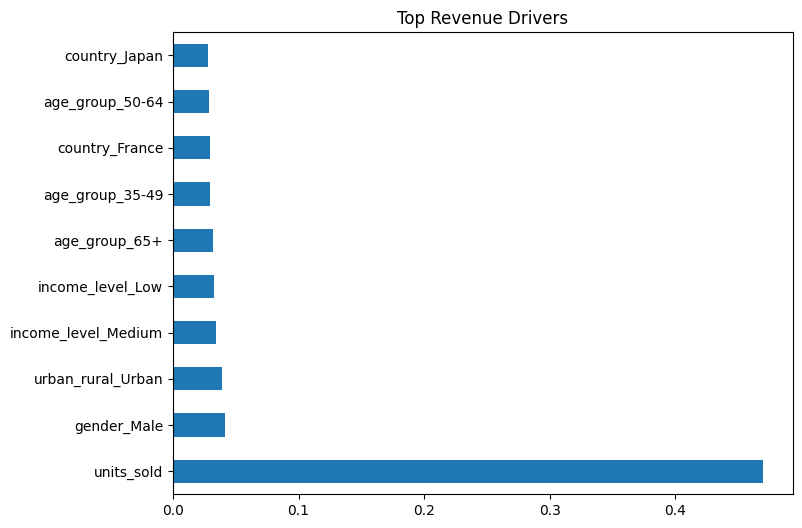

In [12]:
importances = pd.Series(
    rf_reg.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances.head(15))

importances.head(10).plot(kind="barh", figsize=(8,6))
plt.title("Top Revenue Drivers")
plt.show()

In [13]:
# Save dataset
df.to_csv("haagen_dazs_global_dataset.csv", index=False)

# Save models
import joblib
joblib.dump(rf_reg, "rf_regressor.pkl")
joblib.dump(log_model, "logistic_regression.pkl")
joblib.dump(rf_clf, "rf_classifier.pkl")

print("Saved dataset and models successfully.")

Saved dataset and models successfully.
